In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *
from keras.layers import Activation, Dense, Dropout, LSTM
import tensorflow as tf
from tensorflow.keras import Input

In [2]:
df = pd.read_csv("./Resources/working_dataset.csv").set_index("time")
df.index = pd.to_datetime(df.index)
df.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2010-07-18,btc,0.085840,0
2010-07-19,btc,0.080800,0
2010-07-20,btc,0.074736,0
2010-07-21,btc,0.079193,0
2010-07-22,btc,0.058470,0


In [3]:
bitcoin = df.loc[df["Symbol"] == "btc"]
bitcoin.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2010-07-18,btc,0.085840,0
2010-07-19,btc,0.080800,0
2010-07-20,btc,0.074736,0
2010-07-21,btc,0.079193,0
2010-07-22,btc,0.058470,0


In [4]:
bitcoin.count()

Symbol               4610
PriceUSD             4610
Percent of Change    4610
dtype: int64

In [5]:
bitcoin_df = bitcoin.drop(["Symbol", "Percent of Change"], axis=1)
bitcoin_df.head()

,PriceUSD
time,
2010-07-18,0.085840
2010-07-19,0.080800
2010-07-20,0.074736
2010-07-21,0.079193
2010-07-22,0.058470


In [ ]:
#X = bit_df.copy()
#X = X.drop("Price", axis=1)
#y = bit_df["Price"].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

In [ ]:
# Create scaler instance
#X_scaler = sklearn.preprocessing.MinMaxScaler()

# Fit the scaler
#X_scaler.fit(X_train)

# Scale the data
#X_train_scaled = X_scaler.transform(X_train)
#X_test_scaled = X_scaler.transform(X_test)

In [6]:
def normalize_zero_size(df):
    return df / df.iloc[0] - 1

In [7]:
def train_test_split(df, test_size):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [8]:
def extract_window_data(df, window_len, zero_base):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base == True:
            tmp = normalize_zero_size(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [24]:
def prepare_data(df, target_col, window_len, zero_base, test_size): #time_steps):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base == True:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    #X_train = np.reshape(X_train, (int(X_train.shape[0]/time_steps), time_steps, X_train.shape[1]))
    #X_test = np.reshape(X_test, (int(X_test.shape[0]/time_steps), time_steps, X_test.shape[1]))
    return train_data, test_data, X_train, X_test, y_train, y_test

In [25]:
def build_lstm_model(input_data, output_size, neurons, activ_func, dropout, loss, optimizer, metrics):
    model = tf.keras.models.Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
# def build_lstm_model2(time_steps, feats_dim, num_classes, optimizer):
#     x_in = Input(shape=(time_steps, feats_dim))
#     h1 = LSTM(128,return_sequences=True)(x_in)
#     h1 = Dropout(0.5)(h1)
#     h2 = LSTM(64,return_sequences=True)(h1)
#     h2 = Dropout(0.5)(h2)
#     h3 = LSTM(32,return_sequences=True)(h2)
#     h4 = LSTM(32)(h3)
#     h4 = Dropout(0.5)(h4)
#     out = Dense(activation='linear')(h4)
#     model = Model(inputs=x_in, outputs=out)
#     model.compile(optimizer=optimizer,
#                   loss='mean_squared_error',
#                   metrics=['accuracy'])
#     return model

In [61]:
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
target_col = 'PriceUSD'
metrics = 'accuracy'

In [49]:
train, test, X_train, X_test, y_train, y_test = prepare_data( \
    bitcoin_df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

print(f' X (Training): {X_train.shape}')
print(f' X (Testing): {X_test.shape}')
print(f' y (Training): {y_train.shape}')
print(f' y (Testing): {y_test.shape}')

 X (Training): (3683, 5, 1)
 X (Testing): (917, 5, 1)
 y (Training): (3683,)
 y (Testing): (917,)


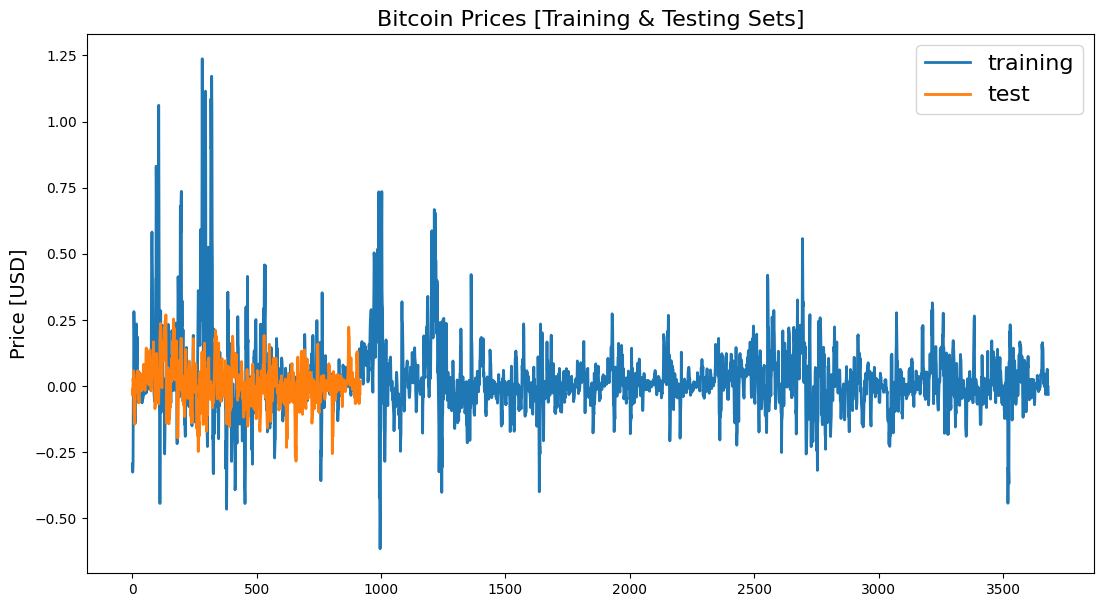

In [30]:
fig, ax = plt.subplots(1, figsize=(13,7))
ax.plot(y_train, label='training', linewidth=2)
ax.plot(y_test, label='test', linewidth=2)
ax.set_ylabel("Price [USD]", fontsize=14)
ax.set_title("Bitcoin Prices [Training & Testing Sets]", fontsize=16)
ax.legend(loc='best', fontsize=16)

In [32]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, activ_func='linear', dropout=dropout, \
    loss=loss, optimizer=optimizer, metrics=metrics)


In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [60]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name='lstm_input'), name='lstm_input', description="created by layer 'lstm_input'")


In [62]:
fit_model = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)

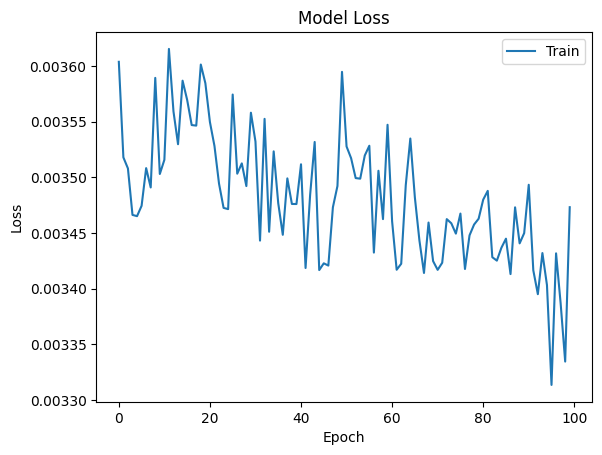

In [63]:
plt.plot(fit_model.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [51]:
model_loss, model_accuracy = model.evaluate(X_train, y_train, verbose=2)
print(f' Loss: {model_loss}, Accuracy: {model_accuracy}')

116/116 - 3s - loss: 0.0034 - accuracy: 8.1455e-04 - 3s/epoch - 22ms/step
 Loss: 0.0033700186759233475, Accuracy: 0.0008145533502101898


In [52]:
model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f' Loss: {model_loss}, Accuracy: {model_accuracy}')

29/29 - 1s - loss: 0.0013 - accuracy: 0.0000e+00 - 725ms/epoch - 25ms/step
 Loss: 0.0012746345018967986, Accuracy: 0.0


In [53]:
y_pred = model.predict(X_test).squeeze()  #The squeeze() function is used to remove single-dimensional entries from the shape of an array

29/29 [==============================] - 1s 34ms/step


In [54]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_pred, y_test)
print(f' Mean Absolute Error: {mae}')

 Mean Absolute Error: 0.02535830262522426


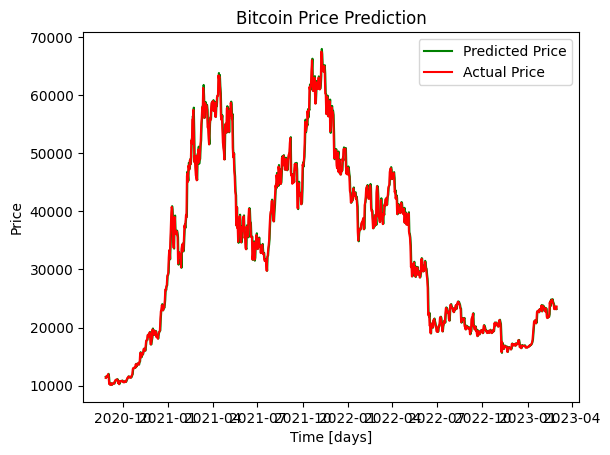

In [55]:
targets = test[target_col][window_len:]
y_pred_inverse = test[target_col].values[:-window_len] * (y_pred + 1) #Inverse Normalization to show actual values

predictions = pd.Series(index=targets.index, data=y_pred_inverse)
plt.plot(predictions, label= "Predicted Price", color="green")
plt.plot(targets, label= "Actual Price", color="red")
plt.title('Bitcoin Price Prediction')
plt.ylabel('Price')
plt.xlabel('Time [days]')
plt.legend(loc='best')
plt.show()


In [56]:
targets

time
2020-08-27    11314.67374
2020-08-28    11527.88303
2020-08-29    11490.76235
2020-08-30    11698.97583
2020-08-31    11678.34823
                 ...     
2023-02-25    23159.81544
2023-02-26    23542.09643
2023-02-27    23504.18942
2023-02-28    23145.94913
2023-03-01    23610.65909
Name: PriceUSD, Length: 917, dtype: float64

In [57]:
y_pred_inverse

array([11505.74311545, 11325.25279617, 11567.47560932, 11511.16490024,
       11744.74901046, 11700.48316367, 12022.74077318, 11398.2984162 ,
       10223.67914926, 10459.00292753, 10143.42259312, 10275.66957527,
       10391.42232739, 10122.95986861, 10257.73821294, 10360.19026006,
       10418.43354295, 10466.72730731, 10339.75709013, 10710.45360518,
       10807.96919423, 11014.35792008, 10956.70122091, 10949.25274686,
       11108.661588  , 10937.39952848, 10455.17116073, 10539.9198526 ,
       10238.6965001 , 10784.58518103, 10697.88406946, 10783.97357699,
       10780.32664846, 10752.34392204, 10874.17080878, 10792.69537342,
       10624.19226245, 10590.6601653 , 10576.61502554, 10696.74980128,
       10804.53880047, 10612.03400309, 10699.80402268, 10938.55119182,
       11112.90575412, 11348.85354713, 11409.32450851, 11591.9148979 ,
       11452.18799932, 11447.29613064, 11532.00714427, 11356.76333867,
       11392.82140588, 11520.68077784, 11790.28947428, 11970.36402797,
      